# Imports

In [1]:
##########
# basics #
##########

import warnings
warnings.filterwarnings('ignore')
import collections
import datetime
import glob
import hashlib
import itertools
import math
import operator
import os
import pickle
import random
import re
import string
import sys
import time

###########
# science #
###########

import scipy as sp
import numpy as np
import pandas as pd
rseed = random.seed(42)

######
# ml #
######

#import xgboost as xgb
import theano as thno
import keras as krs
import tensorflow as tf

###################
# sklearn tooling #
###################

from sklearn import decomposition
from sklearn import preprocessing
from sklearn import metrics
from sklearn import cross_validation
from sklearn import grid_search
from sklearn import pipeline
from sklearn import feature_selection

#################
# visualization #
#################

# plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *
import cufflinks as cf
tls.set_credentials_file(username=os.environ.get('PLOTLY_USERNAME'), api_key=os.environ.get('PLOTLY_APIKEY'))
cf.set_config_file(offline=False, world_readable=True, theme='pearl')

# matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
mpl.rcParams['figure.figsize']=(12.0,4.0)
%matplotlib inline

# seaborn
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted', n_colors=15, desat=None)
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

############
# sys info #
############

%reload_ext watermark
%watermark -a "Ken Cavagnolo" -n -u -v -m -h -g -p numpy,scipy,pandas,sklearn,theano,matplotlib,seaborn,plotly

Using TensorFlow backend.
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Ken Cavagnolo 
last updated: Wed Oct 05 2016 

CPython 2.7.12
IPython 5.1.0

numpy 1.11.1
scipy 0.18.1
pandas 0.19.0
sklearn 0.18
theano 0.8.2
matplotlib 1.5.3
seaborn 0.7.1
plotly 1.12.9

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-38-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : ubuntu
Git hash   : 0eced70c6957019dd0556689997e69cf4e5624cf


# Basic Operations

In [2]:
sess = tf.Session()

In [4]:
hello = tf.constant('Hello, World!')

In [5]:
print sess.run(hello)

Hello, World!


In [6]:
a = tf.placeholder(tf.float32)
b = tf.placeholder(tf.float32)

In [7]:
add = tf.add(a, b)
mul = tf.mul(a, b)

In [11]:
feed = {a: 2,
        b: 3}
print sess.run(add, feed_dict=feed)
print sess.run(mul, feed_dict=feed)

5.0
6.0


In [48]:
a = [[2.],[0.5]]
b = [[2.]]
print a
print
print b

[[2.0], [0.5]]

[[2.0]]


In [52]:
print sess.run(tf.matmul(a, b))
print sess.run(tf.div(a, b))

[[ 4.]
 [ 1.]]
[[ 1.  ]
 [ 0.25]]


# Simple Linear Regression

## Sim Data

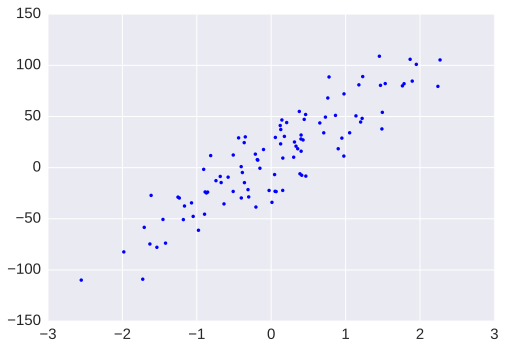

In [31]:
# fake data
from sklearn.datasets import make_regression
n = 100
m = round(0.*n)
rng = np.random.RandomState(0)
X_train, y_train = make_regression(n_samples=n, n_features=1,
                                   random_state=0, noise=20.0,
                                   bias=10.0)

# strong outliers
X_outliers = rng.normal(X_train.min(), X_train.max(), size=(m, 1))
y_outliers = rng.normal(y_train.min(), y_train.max(), size=m)
X_outliers[:m/2, :] += X_train.max() + X_train.mean() / 4.
X_outliers[m/2:, :] += X_train.min() - X_train.mean() / 4.
y_outliers[:m/2] += y_train.min() - y_train.mean() / 4.
y_outliers[m/2:] += y_train.max() + y_train.mean() / 4.

# concat
X_train = np.vstack((X_train, X_outliers))
X_train = X_train.flatten().astype(np.float32)
y_train = np.concatenate((y_train, y_outliers))
y_train = y_train.flatten().astype(np.float32)

# testing
#X_train = np.random.rand(100).astype(np.float32)
#y_train = X_train * 0.1 + 0.3

# plot
plt.plot(X_train, y_train, 'b.')

## Model

In [32]:
# model components
W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
b = tf.Variable(tf.zeros([1]))
y = W * X_train + b

## Learn

In [33]:
# cost func to opt
cost = tf.reduce_mean(tf.square(y - y_train))

In [34]:
# set learning rate and GD step size
lrate = 0.03
optimizer = tf.train.GradientDescentOptimizer(lrate)
train_step = optimizer.minimize(cost)

In [35]:
# start tf sessions
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [36]:
# train
steps = 10000
for step in range(steps):
    sess.run(train_step)
    if step % 1000 == 0:
        print(step, sess.run(W)[0], sess.run(b)[0], sess.run(cost))

(0, 2.8437548, 0.65534031, 2184.9844)
(1000, 42.853325, 8.371645, 456.68594)
(2000, 42.853325, 8.371645, 456.68594)
(3000, 42.853325, 8.371645, 456.68594)
(4000, 42.853325, 8.371645, 456.68594)
(5000, 42.853325, 8.371645, 456.68594)
(6000, 42.853325, 8.371645, 456.68594)
(7000, 42.853325, 8.371645, 456.68594)
(8000, 42.853325, 8.371645, 456.68594)
(9000, 42.853325, 8.371645, 456.68594)


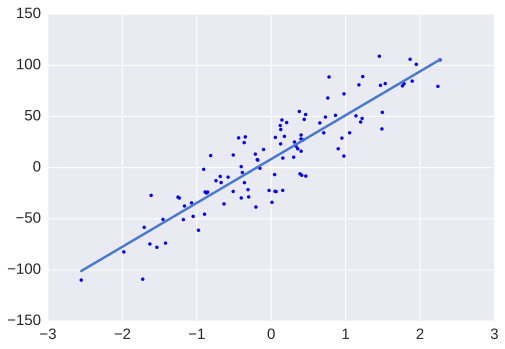

In [37]:
plt.plot(X_train, y_train, 'b.')
xd = np.linspace(X_train.min(), X_train.max(), 50)
yd = xd * sess.run(W)[0] + sess.run(b)[0]
plt.plot(xd, yd)